### Import of required Libraries

In [ ]:
# --- Standard libraries ---
import json
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- IPython (for Jupyter display utilities) ---
from IPython.display import SVG, clear_output

# --- Plotly (interactive plotting) ---
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots  # optional, falls benötigt

# --- Scientific / statistical tools ---
from scipy import stats

# --- Scikit-learn: preprocessing, model selection, metrics, calibration ---
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    log_loss,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder

# --- LightGBM ---
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from optuna.integration import lightgbm as lgb_optuna

# --- TensorFlow / Keras (for AROT model) ---
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Flatten

# --- Domain-specific library: traffic data ---
from traffic.core import Traffic


In [2]:
pd.set_option("display.max_columns", None)

##### Import Data

In [3]:
final_table = pd.read_csv('Final_Table_V2.csv')

#### Create a Copy of Final Table to work with

In [4]:
data = final_table.copy()

##### Decrease the number of Airlines and replace those with not enough appearances with unknown + parking position

In [5]:
def replace_rare_icaos(group, threshold=50):
    # Count ICAO codes within the group
    counts = group['ICAO Code'].value_counts()
    rare_icaos = counts[counts < threshold].index
    # Replace rare ICAOs with e.g., "Rare_North" or "Rare_South"
    group['ICAO Code'] = group['ICAO Code'].apply(
        lambda x: f"Rare_{group.name}" if x in rare_icaos else x
    )
    return group

# Apply the function group-wise by Gate Region
data = data.groupby('Gate Region').apply(replace_rare_icaos).reset_index(drop=True)


C:\Users\kevin\AppData\Local\Temp\ipykernel_91992\921608701.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Gate Region').apply(replace_rare_icaos).reset_index(drop=True)


##### Decrease the number of A/C Types and replace those with not enough appearances with unknown + parking position

In [6]:
def replace_rare_ac_types(group, threshold=50):
    # Count A/C Types within the group
    counts = group['A/C Type'].value_counts()
    rare_types = counts[counts < threshold].index
    # Replace rare A/C Types with e.g., "Rare_Heavy", "Rare_Light", etc.
    group['A/C Type'] = group['A/C Type'].apply(
        lambda x: f"Rare_{group.name}" if x in rare_types else x
    )
    return group

# Apply the function group-wise by ICAO Weight Turbulence Category
data = data.groupby('ICAO Weight Turbulence Category').apply(replace_rare_ac_types).reset_index(drop=True)


C:\Users\kevin\AppData\Local\Temp\ipykernel_91992\2761709303.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('ICAO Weight Turbulence Category').apply(replace_rare_ac_types).reset_index(drop=True)


#### Determine the Difference of the Entry Time between successive Arrivals

In [ ]:
# Cleanly sort and reset integer index
data = data.sort_values(by="Time of Prediction", ignore_index=True)

# Parse datetime fields
data['Entry Time'] = pd.to_datetime(data['Entry Time'])
data['Exit Time']  = pd.to_datetime(data['Exit Time'])

# Time difference to the next entry time (in seconds)
data['Entry Time Difference (s)'] = (
    data['Entry Time'].shift(-1) - data['Entry Time']
).dt.total_seconds()


#### Determine Time Buffers

In [ ]:
# Cleanly sort and reset integer index
data = data.sort_values(by="Time of Prediction", ignore_index=True)

# Time difference to the next entry time (in seconds)
data['Time Difference (s)'] = (
    data['Entry Time'].shift(-1) - data['Exit Time']
).dt.total_seconds()


In [9]:
data

,Flight ID,Entry Time,Exit Time,ICAO Code,A/C Type,ICAO Aircraft Type,Propulsion Type,Number of Engines,MALW [kg],ICAO Weight Turbulence Category,Gate Region,RET,ROT [s],Time of Prediction,Wind speed [kt],Wind direction [°],Visibility Category,Temperature [°C],Meteo idx,Precipitation [mm],Precipitation idx,Precipitation Timestamp,Hour sin,Hour cos,Minute sin,Minute cos,Day of week sin,Day of week cos,Month sin,Month cos,Year sin,Year cos,Day/Night,No Wind,Wind Variable,Wind direction sin,Wind direction cos,Headwind [kt],Crosswind [kt],Traffic Intensity RWY 10,Traffic Intensity RWY 14,Departure Traffic Intensity RWY 16,Arrival Traffic Intensity RWY 16,Traffic Intensity RWY 16,Departure Traffic Intensity RWY 28,Arrival Traffic Intensity RWY 28,Traffic Intensity RWY 28,Traffic Intensity RWY 32,Departure Traffic Intensity RWY 34,Arrival Traffic Intensity RWY 34,Traffic Intensity RWY 34,Airport Departure Traffic Intensity,Airport Arrival Traffic Intensity,Total Airport Traffic Intensity,Time Reserve [s],Number of preceding Traffic,Preceding Traffic ICAO Code,Preceding Traffic A/C Type,Preceding Traffic ICAO Aircraft Type,Preceding Traffic Propulsion Type,Preceding Traffic Number of Engines,Preceding Traffic MALW [kg],Preceding Traffic ICAO Weight Turbulence Category,Preceding Traffic Gate,Preceding Aircraft Geoaltitude,Preceding Aircraft Speed,Distance to Preceding Aircraft,Number of Successive Traffic,Successive Traffic ID,Successive Traffic A/C Type,Successive Traffic Geoaltitude,Successive Traffic Groundspeed,Successive Traffic Track,Successive Traffic Vertical Rate,Successive Traffic Distance,Successive Traffic Track sin,Successive Traffic Track cos,Successor Aligned,ROT Previous Flight [s],Average ROT Previous 5 Flight [s],Average ROT Previous Flight (Intensity) [s],ROT Previous Flight same A/C Type [s],Average ROT Previous 5 Flights same A/C Type [s],Average ROT Previous Flight same A/C Type (Intensity) [s],Average ROT Previous Flight same A/C Type Total [s],ROT Previous Flight same ICAO Weight Category [s],Average ROT Previous 5 Flights same ICAO Weight Category [s],Average ROT Previous Flight same ICAO Weight Category (Intensity) [s],Average ROT Previous Flight same ICAO Weight Category Total [s],Average ROT Total [s],groundspeed at prediction,geoaltitude at prediction,vertical_rate at prediction,distance at prediction,station,reference_timestamp,temp_2m,temp_5cm,temp_surface,temp_chill,rh_2m,dewpoint_2m,vapour_pressure,pressure_qfe,pressure_qnh,pressure_qff,geopot_850,geopot_700,gust_1s_ms,wind_vec_ms,wind_scalar_ms,wind_dir,foehn_idx,wind_scalar_kmh,gust_3s_ms,gust_1s_kmh,gust_3s_kmh,precip_10min,snow_depth,rad_global,rad_diffuse,rad_lw_in,rad_lw_out,rad_sw_reflect,sunshine_10min,new_wind_speed_kt,new_headwind_kt,new_crosswind_kt,H1,H2,H3,Entry Time Difference (s),Time Difference (s)
0,SIA346_291674,2024-03-01 06:23:00+00:00,2024-03-01 06:23:57+00:00,SIA,B77W,L2J,Jet,2.0,251290.0,Heavy,North,H1,57.0,2024-03-01 06:21:26+00:00,1.0,0.0,3,5.0,16.0,0.6,30.0,2024-03-01 06:00:00+00:00,1.0,0.5,0.904508,0.206107,0.283058,0.049516,1.0,0.5,0.999013,0.531395,Day,False,True,0.000000,0.00000,1.00,1.00,0,0,0,0,0,7,0,7,0,0,0,0,7,0,7,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1325.000000,0.0,13.752771,0.0,NaN,NaN,16000.0,417.0,317.231857,0.0,19.097551,0.000000,0.000000,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.0,2950.0,-896.0,4.003528,KLO,2024-03-01 06:20:00+00:00,5.1,4.4,4.6,5.1,97.1,4.7,8.5,959.0,1009.2,1010.3,NaN,NaN,1.5,1.1,1.1,106.0,NaN,4.0,1.5,5.4,5.4,0.4,0.0,2,1.0,336,NaN,NaN,0,2.159827,1.85,-1.12,0,0,0,582.0,525.0
1,ETH736_1162,2024-03-01 06:32:42+00:00,2024-03-01 06:33:36+00:00,ETH,A359,L2J,Jet,2.0,207000.0,Heavy,South,H1,54.0,2024-03-01 06:31:12+00:00,1.0,0.0,3,5.0,16.0,0.6,30.0,2024-03-01 06:00:00+00:00,1.0,0.5,0.447736,0.002739,0.283058,0.049516,1.0,0.5,0.999013,0.531395,Day,False,True,0.000000,0.00000,1.00,1.00,0,1,0,0,0,9,0,9,0,0,0,0,9,1,10,525.0,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1325.000000,0.0,13.752771,0.0,NaN,

#### Extract only Data which vacated the Runway via an valid Exit Taxiway

In [10]:
data = data[(data['RET'] == 'H1') | (data['RET'] == 'H2') | (data['RET'] == 'H3')] # H3 included for Time Buffer Plot. Will be removed in another step

#### Define a lower threshold of 39 secondes to remove faulty data

In [11]:
data = data[data['ROT [s]'] >=39]

In [12]:
data = data[data['Entry Time Difference (s)'] > 0]

#### Set Categorical Types

In [13]:
data['A/C Type'] = data['A/C Type'].astype('category')
data['ICAO Code'] = data['ICAO Code'].astype('category')
data['ICAO Weight Turbulence Category'] = data['ICAO Weight Turbulence Category'].astype('category')
data['Propulsion Type'] = data['Propulsion Type'].astype('category')
data['Day/Night'] = data['Day/Night'].astype('category')
data['No Wind'] = data['No Wind'].astype('category')
data['Wind Variable'] = data['Wind Variable'].astype('category')
data['Gate Region'] = data['Gate Region'].astype('category')

In [ ]:
# List of all flight IDs to be removed
invalid_ids = [
    # H1 - Long ROTs
    "SAS841_74600", "AEA91MP_5645", "SWR4GV_272636", "EDW675Z_191415",
    "SWR504W_144961", "SPEMC_64994", "SWR9GW_88322", "SWR2EP_134507",
    "SWR296W_280795", "SWR1TC_125514", "SWR969_80375", "DLH8WN_29304",
    # H1 - Short ROTs
    "SWR4CQ_236343", "DISAG_33952", "SWR9LZ_128323", "EWG95AW_269167",
    "SWR6MW_223600", "SWR3BY_105353", "SWR339H_132594",
    # H1 - Other observations
    "AUA55C_45096", "SXS7SL_251961", "SKV444_46316", "EJU5189_45326",
    "LDX20C_46560", "EWG59L_261077", "VJT518_261031", "EJU96HY_45377",
    "OEFXY_45632", "OEFXY_45636",
    # H2 - Long ROTs
    "SWR589X_197642", "KAL917_289693", "SWR262C_114944", "AUA5U_46704",
    "SWR2HE_111023", "SWR2DG_96864", "DCSEB_32456", "EWG64R_20879",
    "SWR71Y_279675", "SWR457_141457", "SWR539L_276851", "SWR4MY_85273",
    "SWR438A_87128", "SWR5KP_133206",
    # H2 - Short ROTs
    "SWR4GV_201277", "DLH8CM_16669", "SXS9UC_253202", "SWR30M_194526",
    "SWR63D_99758", "SWR296W_285509", "SWR5GZ_115709", "EDW215P_195137",
    "SWR2DG_196962", "SWR2121_121074", "SWR98X_84057", "SWR8WK_160440",
    "SWR5CL_121762", "SWR189_202667", "SWR9LZ_126613", "SWR622P_79915",
    # H3 - Short ROTs
    "LMJ920F_67939",
    # H3 - Other
    "RGA01_245094",
]

# Filter out invalid flight IDs
data = data[~data["Flight ID"].isin(invalid_ids)].copy()

# Filter out unwanted aircraft types
invalid_ac_types = ["SF25", "PA18", "PA31", "PA34", "TB20", "C207", "DA40"]
data = data[~data['A/C Type'].isin(invalid_ac_types)]

# Create a copy for plotting
data_buffer_plot = data.copy()


##### Remove H3 from dataset

In [15]:
data = data[(data['RET'] == 'H1') | (data['RET'] == 'H2')]

#### Remove Flights which are considered as irrelevant due to their Time Difference

In [16]:
heavy = data['ICAO Weight Turbulence Category'].isin(['Heavy', 'Super', 'H', 'J'])

mask = (heavy  & (data['Entry Time Difference (s)'] <= 180)) | \
       (~heavy & (data['Entry Time Difference (s)'] <= 120))

data = data[mask]

#### Define X_ret for RET prediction

In [17]:
X_ret = data[[
    'ICAO Code',
    'MALW [kg]',
    'Gate Region',
    'new_headwind_kt',
    'new_crosswind_kt',
    'Visibility Category',
    'temp_2m',
    'pressure_qnh',
    'precip_10min',
    'Month sin',
    'Month cos',
    'Day of week sin',
    'Day of week cos',
    'groundspeed at prediction',
]]

#### Filter categorical Columns in X_ret

In [18]:
categorical_columns = [
    'ICAO Code',
    'ICAO Weight Turbulence Category',
    'Gate Region',
]


#### Identify Categorical Feature Indices

In [19]:
categorical_columns_in_X = [col for col in categorical_columns if col in X_ret.columns]
categorical_feature_indices = [X_ret.columns.get_loc(col) for col in categorical_columns_in_X]

#### Remove NaN from the Dataset (only based on X_ret)

In [20]:
X_ret = X_ret.dropna()

#### Remove special characters from the column names

In [21]:
X_ret_columns_names = X_ret.columns
X_ret.columns = X_ret.columns.str.replace(r"[\[\]<>]", "", regex=True)

#### Define Target

In [22]:
y_ret = data.loc[X_ret.index, ['RET']]

#### Encode Target

In [23]:
# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y_ret)

c:\Users\kevin\Desktop\Unterlagen\Work\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Split Set in a Set for RET Predcition Model and in a Set for ROT Prediction Model (ROT Set is the Test set of the RET Set)

In [24]:
X_ret, X_rot, y_ret, y_rot = train_test_split(
    X_ret, y_encoded, test_size=0.5, random_state=42
)

#### Define Train and Validation Set of the RET Set

In [25]:
X_ret_train, X_ret_val, y_ret_train, y_ret_val = train_test_split(
    X_ret, y_ret, test_size=0.2, random_state=42
)

#### Encode Categorical Features

In [26]:
ordinal_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [ ]:
X_ret_train_encoded = X_ret_train.copy()
X_ret_val_encoded = X_ret_val.copy()
X_ret_rot_encoded = X_rot.copy()

# Encode only the categorical columns
X_ret_train_encoded[categorical_columns_in_X] = ordinal_encoder.fit_transform(X_ret_train[categorical_columns_in_X])
X_ret_val_encoded[categorical_columns_in_X] = ordinal_encoder.transform(X_ret_val[categorical_columns_in_X])
X_ret_rot_encoded[categorical_columns_in_X] = ordinal_encoder.transform(X_rot[categorical_columns_in_X])

X_ret_resampled, y_ret_resampled = X_ret_train_encoded, y_ret_train # Originaly we applied SMOTENC which was later removed

#### Define the RET Model and Optuna Hyperparameter Optimization

In [ ]:
# --- Set seeds ---
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)

# --- Training and validation data ---
train_data = lgb.Dataset(X_ret_resampled, label=y_ret_resampled)
valid_data = lgb.Dataset(X_ret_val_encoded, label=y_ret_val)

# --- Base parameters ---
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    "seed": 42,
    "feature_fraction_seed": 42,
    "bagging_seed": 42,
    "data_random_seed": 42,
    "deterministic": True,
    "num_threads": 1,
}

# --- Optuna tuning (no k-fold) ---
tuner = lgb_optuna.LightGBMTuner(
    params=params,
    train_set=train_data,
    valid_sets=[valid_data],
    valid_names=["validation"],
    num_boost_round=2000,
    callbacks=[early_stopping(stopping_rounds=50)],
    optuna_seed=42,
)

tuner.run()

# --- Best parameters & score ---
best_params = tuner.best_params
best_score = tuner.best_score
best_booster = tuner.get_best_booster()
best_iter = best_booster.best_iteration

print("\nBest Parameters:")
for k, v in best_params.items(): print(f"  {k}: {v}")
print(f"\nBest Validation Logloss: {best_score:.5f}")
print(f"Best Iteration: {best_iter}")

# --- Final sklearn model (fit) with fixed random state ---
best_params.update({
    "n_estimators": best_iter,
    "objective": "binary",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": 42,
    "num_threads": 1,
})

lgbm_model = lgb.LGBMClassifier(**best_params)

lgbm_model.fit(
    X_ret_resampled, y_ret_resampled,
    eval_set=[(X_ret_val_encoded, y_ret_val)],
    eval_metric=["logloss", "auc", "aucpr"],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)],
)

# --- Evaluation ---
y_val_pred_proba = lgbm_model.predict_proba(X_ret_val_encoded)[:, 1]
print("\nValidation Logloss:", log_loss(y_ret_val, y_val_pred_proba))
print("Validation AUC:", roc_auc_score(y_ret_val, y_val_pred_proba))


[I 2025-10-31 17:12:08,409] A new study created in memory with name: no-name-a3a38d3b-26a6-4800-8e9b-794d21c33424
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.456168:  14%|#4        | 1/7 [00:01<00:06,  1.09s/it]

Early stopping, best iteration is:
[222]	validation's binary_logloss: 0.456168
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.456168:  29%|##8       | 2/7 [00:02<00:05,  1.08s/it]

Early stopping, best iteration is:
[221]	validation's binary_logloss: 0.456184
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.454589:  43%|####2     | 3/7 [00:03<00:05,  1.26s/it]

Early stopping, best iteration is:
[287]	validation's binary_logloss: 0.454589
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.454589:  57%|#####7    | 4/7 [00:04<00:03,  1.15s/it]

Early stopping, best iteration is:
[205]	validation's binary_logloss: 0.457316
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.454589:  71%|#######1  | 5/7 [00:05<00:02,  1.21s/it]

Early stopping, best iteration is:
[253]	validation's binary_logloss: 0.45479
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.454589:  86%|########5 | 6/7 [00:07<00:01,  1.16s/it]

Early stopping, best iteration is:
[154]	validation's binary_logloss: 0.458028
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.454589: 100%|##########| 7/7 [00:08<00:00,  1.22s/it]


Early stopping, best iteration is:
[258]	validation's binary_logloss: 0.455954


num_leaves, val_score: 0.454589:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:   5%|5         | 1/20 [00:01<00:24,  1.27s/it]

Early stopping, best iteration is:
[97]	validation's binary_logloss: 0.459453
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:  10%|#         | 2/20 [00:02<00:24,  1.35s/it]

Early stopping, best iteration is:
[39]	validation's binary_logloss: 0.46821
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	validation's binary_logloss: 0.462294


num_leaves, val_score: 0.454589:  15%|#5        | 3/20 [00:04<00:26,  1.54s/it]

Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:  20%|##        | 4/20 [00:05<00:24,  1.50s/it]

Early stopping, best iteration is:
[345]	validation's binary_logloss: 0.457599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:  25%|##5       | 5/20 [00:08<00:29,  1.94s/it]

Early stopping, best iteration is:
[992]	validation's binary_logloss: 0.463694
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:  30%|###       | 6/20 [00:10<00:25,  1.81s/it]

Early stopping, best iteration is:
[113]	validation's binary_logloss: 0.460997
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:  35%|###5      | 7/20 [00:11<00:21,  1.64s/it]

Early stopping, best iteration is:
[52]	validation's binary_logloss: 0.464756
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:  40%|####      | 8/20 [00:12<00:17,  1.46s/it]

Early stopping, best iteration is:
[120]	validation's binary_logloss: 0.456424
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:  45%|####5     | 9/20 [00:14<00:17,  1.57s/it]

Early stopping, best iteration is:
[58]	validation's binary_logloss: 0.463032
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:  50%|#####     | 10/20 [00:15<00:15,  1.53s/it]

Early stopping, best iteration is:
[66]	validation's binary_logloss: 0.460762
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:  55%|#####5    | 11/20 [00:17<00:13,  1.50s/it]

Early stopping, best iteration is:
[168]	validation's binary_logloss: 0.45635
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:  60%|######    | 12/20 [00:19<00:13,  1.74s/it]

Early stopping, best iteration is:
[46]	validation's binary_logloss: 0.465794
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454589:  65%|######5   | 13/20 [00:21<00:12,  1.79s/it]

Early stopping, best iteration is:
[66]	validation's binary_logloss: 0.462782
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454489:  70%|#######   | 14/20 [00:22<00:10,  1.72s/it]

Early stopping, best iteration is:
[211]	validation's binary_logloss: 0.454489
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454489:  75%|#######5  | 15/20 [00:24<00:08,  1.64s/it]

Early stopping, best iteration is:
[173]	validation's binary_logloss: 0.456802
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454489:  80%|########  | 16/20 [00:25<00:05,  1.46s/it]

Early stopping, best iteration is:
[150]	validation's binary_logloss: 0.456283
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454489:  85%|########5 | 17/20 [00:26<00:04,  1.39s/it]

Early stopping, best iteration is:
[103]	validation's binary_logloss: 0.457931
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454489:  90%|######### | 18/20 [00:27<00:02,  1.36s/it]

Early stopping, best iteration is:
[79]	validation's binary_logloss: 0.461917
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	validation's binary_logloss: 0.457326


num_leaves, val_score: 0.454489:  95%|#########5| 19/20 [00:29<00:01,  1.39s/it]

Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.454489: 100%|##########| 20/20 [00:30<00:00,  1.51s/it]


Early stopping, best iteration is:
[103]	validation's binary_logloss: 0.457977


bagging, val_score: 0.454489:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.454489:  10%|#         | 1/10 [00:01<00:11,  1.30s/it]

Early stopping, best iteration is:
[146]	validation's binary_logloss: 0.457166
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.454489:  20%|##        | 2/10 [00:02<00:10,  1.36s/it]

Early stopping, best iteration is:
[140]	validation's binary_logloss: 0.456338
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.454489:  30%|###       | 3/10 [00:04<00:09,  1.40s/it]

Early stopping, best iteration is:
[138]	validation's binary_logloss: 0.460916
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.454489:  40%|####      | 4/10 [00:06<00:09,  1.59s/it]

Early stopping, best iteration is:
[208]	validation's binary_logloss: 0.455648
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.454489:  50%|#####     | 5/10 [00:07<00:07,  1.55s/it]

Early stopping, best iteration is:
[149]	validation's binary_logloss: 0.455828
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.454489:  60%|######    | 6/10 [00:09<00:06,  1.54s/it]

Early stopping, best iteration is:
[143]	validation's binary_logloss: 0.458008
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.454489:  70%|#######   | 7/10 [00:10<00:04,  1.50s/it]

Early stopping, best iteration is:
[124]	validation's binary_logloss: 0.455325
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.454489:  80%|########  | 8/10 [00:11<00:02,  1.50s/it]

Early stopping, best iteration is:
[151]	validation's binary_logloss: 0.454539
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.454489:  90%|######### | 9/10 [00:12<00:01,  1.33s/it]

Early stopping, best iteration is:
[91]	validation's binary_logloss: 0.461021
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.454489: 100%|##########| 10/10 [00:14<00:00,  1.43s/it]


Early stopping, best iteration is:
[119]	validation's binary_logloss: 0.459584


feature_fraction_stage2, val_score: 0.454489:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.454489:  17%|#6        | 1/6 [00:01<00:07,  1.50s/it]

Early stopping, best iteration is:
[211]	validation's binary_logloss: 0.454489
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.454489:  33%|###3      | 2/6 [00:03<00:05,  1.50s/it]

Early stopping, best iteration is:
[211]	validation's binary_logloss: 0.454489
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.453255:  50%|#####     | 3/6 [00:04<00:04,  1.53s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.453255:  67%|######6   | 4/6 [00:06<00:03,  1.57s/it]

Early stopping, best iteration is:
[180]	validation's binary_logloss: 0.45634
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.453255:  83%|########3 | 5/6 [00:07<00:01,  1.63s/it]

Early stopping, best iteration is:
[234]	validation's binary_logloss: 0.459487
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.453255: 100%|##########| 6/6 [00:09<00:00,  1.57s/it]


Early stopping, best iteration is:
[180]	validation's binary_logloss: 0.45634


regularization_factors, val_score: 0.453255:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:   5%|5         | 1/20 [00:01<00:27,  1.47s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:  10%|#         | 2/20 [00:02<00:24,  1.39s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:  15%|#5        | 3/20 [00:04<00:23,  1.38s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:  20%|##        | 4/20 [00:05<00:21,  1.36s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:  25%|##5       | 5/20 [00:06<00:19,  1.31s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:  30%|###       | 6/20 [00:08<00:18,  1.30s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:  35%|###5      | 7/20 [00:09<00:17,  1.33s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:  40%|####      | 8/20 [00:10<00:15,  1.31s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:  45%|####5     | 9/20 [00:11<00:14,  1.32s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:  50%|#####     | 10/20 [00:13<00:12,  1.30s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:  55%|#####5    | 11/20 [00:14<00:11,  1.29s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.453255:  60%|######    | 12/20 [00:15<00:10,  1.28s/it]

Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.452890:  65%|######5   | 13/20 [00:17<00:09,  1.29s/it]

Early stopping, best iteration is:
[177]	validation's binary_logloss: 0.45289
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.452890:  70%|#######   | 14/20 [00:18<00:08,  1.35s/it]

Early stopping, best iteration is:
[208]	validation's binary_logloss: 0.452933
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.452890:  75%|#######5  | 15/20 [00:19<00:06,  1.25s/it]

Early stopping, best iteration is:
[109]	validation's binary_logloss: 0.457924
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.452890:  80%|########  | 16/20 [00:21<00:05,  1.40s/it]

Early stopping, best iteration is:
[238]	validation's binary_logloss: 0.455046
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.452890:  85%|########5 | 17/20 [00:22<00:03,  1.31s/it]

Early stopping, best iteration is:
[123]	validation's binary_logloss: 0.457817
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.452890:  90%|######### | 18/20 [00:23<00:02,  1.34s/it]

Early stopping, best iteration is:
[189]	validation's binary_logloss: 0.454424
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.452890:  95%|#########5| 19/20 [00:25<00:01,  1.33s/it]

Early stopping, best iteration is:
[155]	validation's binary_logloss: 0.456598
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.452890: 100%|##########| 20/20 [00:26<00:00,  1.32s/it]


Early stopping, best iteration is:
[163]	validation's binary_logloss: 0.453255


min_child_samples, val_score: 0.452890:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.452890:  20%|##        | 1/5 [00:01<00:05,  1.42s/it]

Early stopping, best iteration is:
[173]	validation's binary_logloss: 0.457342
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.452890:  40%|####      | 2/5 [00:02<00:03,  1.28s/it]

Early stopping, best iteration is:
[147]	validation's binary_logloss: 0.455464
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.452890:  60%|######    | 3/5 [00:03<00:02,  1.25s/it]

Early stopping, best iteration is:
[153]	validation's binary_logloss: 0.454255
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.452890:  80%|########  | 4/5 [00:04<00:01,  1.15s/it]

Early stopping, best iteration is:
[100]	validation's binary_logloss: 0.455561
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.452890: 100%|##########| 5/5 [00:06<00:00,  1.23s/it]

Early stopping, best iteration is:
[151]	validation's binary_logloss: 0.455758

Best Parameters:
  objective: binary
  metric: binary_logloss
  verbosity: -1
  boosting_type: gbdt
  feature_pre_filter: False
  seed: 42
  feature_fraction_seed: 42
  bagging_seed: 42
  data_random_seed: 42
  deterministic: True
  num_threads: 1
  lambda_l1: 0.014607715801349994
  lambda_l2: 2.0750022643683693e-06
  num_leaves: 45
  feature_fraction: 0.9799999999999999
  bagging_fraction: 1.0
  bagging_freq: 0
  min_child_samples: 20

Best Validation Logloss: 0.45289
Best Iteration: 177
Training until validation scores don't improve for 50 rounds


[50]	valid_0's auc: 0.797168	valid_0's binary_logloss: 0.462158
[100]	valid_0's auc: 0.80411	valid_0's binary_logloss: 0.456362
[150]	valid_0's auc: 0.806915	valid_0's binary_logloss: 0.454646
Did not meet early stopping. Best iteration is:
[177]	valid_0's auc: 0.809566	valid_0's binary_logloss: 0.45289

Validation Logloss: 0.4528903961322931
Validation AUC: 0.8095659972452458


#### Train Model

#### Evaluate Training

In [ ]:
# Predict class probabilities for the training set
probs_ret_train = lgbm_model.predict_proba(X_ret_resampled)  # Shape: (n_samples, n_classes)

# Convert probabilities to class predictions (hard labels)
y_ret_train_pred = np.argmax(probs_ret_train, axis=1)

# Inverse transform to original labels if LabelEncoder was used
y_ret_train_pred_labels = le.inverse_transform(y_ret_train_pred)
y_ret_train_labels = le.inverse_transform(y_ret_resampled)

# --- Classification Metrics ---
print("Training Accuracy (LightGBM):", accuracy_score(y_ret_resampled, y_ret_train_pred))
print("Training Log Loss:", log_loss(y_ret_resampled, probs_ret_train))
print("\nClassification Report (LightGBM):")
print(classification_report(y_ret_resampled, y_ret_train_pred, target_names=le.classes_))

# --- Calibration Curve (per class) ---
traces = []
for i, class_label in enumerate(le.classes_):
    y_true_bin = (y_ret_resampled == i).astype(int)
    prob_true, prob_pred = calibration_curve(y_true_bin, probs_ret_train[:, i], n_bins=10)
    traces.append(go.Scatter(
        x=prob_pred,
        y=prob_true,
        mode='lines+markers',
        name=f'Class: {class_label}'
    ))

# Diagonal reference line
traces.append(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='gray'),
    showlegend=False
))

fig_cal = go.Figure(data=traces)
fig_cal.update_layout(
    title="Calibration Curve – Training Data",
    xaxis_title="Predicted Probability",
    yaxis_title="Observed Frequency",
    width=600,
    height=500
)
fig_cal.show()

# --- Classification Report (Plotly Table) ---
report = classification_report(y_ret_resampled, y_ret_train_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report).T.reset_index().rename(columns={'index': 'Class'})
report_df = report_df.round(3)


Training Accuracy (LightGBM): 0.8609625668449198
Training Log Loss: 0.3238323729140639

Classification Report (LightGBM):
              precision    recall  f1-score   support

          H1       0.84      0.98      0.91     15563
          H2       0.94      0.58      0.71      6690

    accuracy                           0.86     22253
   macro avg       0.89      0.78      0.81     22253
weighted avg       0.87      0.86      0.85     22253



#### Evaluate Validation

In [ ]:
# Predict class probabilities for the validation set
probs_ret_val = lgbm_model.predict_proba(X_ret_val_encoded)  # Shape: (n_samples, n_classes)

# Convert probabilities to class predictions
y_ret_val_pred = np.argmax(probs_ret_val, axis=1)

# Inverse transform to original labels if LabelEncoder was used
y_ret_val_pred_labels = le.inverse_transform(y_ret_val_pred)
y_ret_val_labels = le.inverse_transform(y_ret_val)

# --- Classification Metrics ---
print("Validation Accuracy (LightGBM):", accuracy_score(y_ret_val, y_ret_val_pred))
print("Validation Log Loss:", log_loss(y_ret_val, probs_ret_val))
print("\nClassification Report (LightGBM):")
print(classification_report(y_ret_val, y_ret_val_pred, target_names=le.classes_))


# --- Predict class probabilities and labels ---
probs_ret_val = lgbm_model.predict_proba(X_ret_val_encoded)
y_ret_val_pred = np.argmax(probs_ret_val, axis=1)
y_ret_val_pred_labels = le.inverse_transform(y_ret_val_pred)
y_ret_val_labels = le.inverse_transform(y_ret_val)

# --- Calibration Curve per class ---
traces = []
for i, class_label in enumerate(le.classes_):
    y_true_bin = (y_ret_val == i).astype(int)
    prob_true, prob_pred = calibration_curve(y_true_bin, probs_ret_val[:, i], n_bins=10)
    traces.append(go.Scatter(
        x=prob_pred,
        y=prob_true,
        mode='lines+markers',
        name=f'Class: {class_label}'
    ))

traces.append(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='gray'),
    showlegend=False
))

fig_cal = go.Figure(data=traces)
fig_cal.update_layout(
    title="Calibration Curve – Validation Data",
    xaxis_title="Predicted Probability",
    yaxis_title="Observed Frequency",
    width=600,
    height=500
)
fig_cal.show()


Validation Accuracy (LightGBM): 0.789000718907261
Validation Log Loss: 0.4528903961322931

Classification Report (LightGBM):
              precision    recall  f1-score   support

          H1       0.79      0.95      0.86      3907
          H2       0.78      0.41      0.54      1657

    accuracy                           0.79      5564
   macro avg       0.78      0.68      0.70      5564
weighted avg       0.79      0.79      0.77      5564



#### ROT Set

In [ ]:
# Predict class probabilities for the test set
probs_ret_rot = lgbm_model.predict_proba(X_ret_rot_encoded)  # Shape: (n_samples, n_classes)

# Convert probabilities to class predictions
y_ret_rot_pred = np.argmax(probs_ret_rot, axis=1)

# Inverse transform to original labels if LabelEncoder was used
y_ret_rot_pred_labels = le.inverse_transform(y_ret_rot_pred)
y_ret_rot_labels = le.inverse_transform(y_rot)

# --- Classification Metrics ---
print("Test Accuracy (LightGBM):", accuracy_score(y_rot, y_ret_rot_pred))
print("Test Log Loss:", log_loss(y_rot, probs_ret_rot))
print("\nClassification Report (LightGBM):")
print(classification_report(y_rot, y_ret_rot_pred, target_names=le.classes_))

# --- Predict class probabilities and labels ---
probs_ret_rot = lgbm_model.predict_proba(X_ret_rot_encoded)
y_ret_rot_pred = np.argmax(probs_ret_rot, axis=1)
y_ret_rot_pred_labels = le.inverse_transform(y_ret_rot_pred)
y_ret_rot_labels = le.inverse_transform(y_rot)

# --- Calibration Curve per class ---
traces = []
for i, class_label in enumerate(le.classes_):
    y_true_bin = (y_rot == i).astype(int)
    prob_true, prob_pred = calibration_curve(y_true_bin, probs_ret_rot[:, i], n_bins=10)
    traces.append(go.Scatter(
        x=prob_pred,
        y=prob_true,
        mode='lines+markers',
        name=f'Class: {class_label}'
    ))

traces.append(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='gray'),
    showlegend=False
))

fig_cal = go.Figure(data=traces)
fig_cal.update_layout(
    title="Calibration Curve – Test Data",
    xaxis_title="Predicted Probability",
    yaxis_title="Observed Frequency",
    width=600,
    height=500
)
fig_cal.show()

Test Accuracy (LightGBM): 0.7936228341361709
Test Log Loss: 0.44340115380037404

Classification Report (LightGBM):
              precision    recall  f1-score   support

          H1       0.80      0.95      0.87     19649
          H2       0.77      0.43      0.55      8169

    accuracy                           0.79     27818
   macro avg       0.78      0.69      0.71     27818
weighted avg       0.79      0.79      0.77     27818



#### Calibration Curve Plot for Paper

In [ ]:
# Create output directory if it does not exist
output_dir = 'Plots'
os.makedirs(output_dir, exist_ok=True)

# Define color and marker sets
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta', 'olive', 'grey', 'black']
symbols = ['circle', 'square', 'triangle-up', 'diamond', 'cross', 'x', 'triangle-down',
           'triangle-left', 'triangle-right', 'star']

# Compute calibration curves for each class
traces = []
for i, class_label in enumerate(le.classes_):
    y_true_bin = (y_rot == i).astype(int)
    prob_true, prob_pred = calibration_curve(y_true_bin, probs_ret_rot[:, i], n_bins=10)

    traces.append(go.Scatter(
        x=prob_pred,
        y=prob_true,
        mode='lines+markers',
        name=f'Class: {class_label}',
        line=dict(color=colors[i % len(colors)]),
        marker=dict(
            size=10,
            symbol=symbols[i % len(symbols)],
            color=colors[i % len(colors)],
            line=dict(width=1, color='black'),
            opacity=0.7
        )
    ))

# Add perfect calibration reference line
reference_line = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', dash='dash', width=2),
    name='Perfect Calibration'
)

# Define layout
layout = go.Layout(
    width=800,
    height=500,
    xaxis=dict(
        title='Predicted Probability',
        title_font=dict(size=22),
        tickfont=dict(size=18),
        range=[0, 1]
    ),
    yaxis=dict(
        title='Observed Frequency',
        title_font=dict(size=22),
        tickfont=dict(size=18),
        range=[0, 1]
    ),
    showlegend=True,
    legend=dict(x=0.01, y=0.99, font=dict(size=14)),
    margin=dict(l=50, r=50, t=40, b=50)
)

# Create and save figure
fig_cal = go.Figure(data=traces + [reference_line], layout=layout)
fig_cal.write_image(os.path.join(output_dir, 'calibration_curve_test.pdf'), scale=5)

# Display interactive plot
fig_cal.show()


#### Save Predicted Probabilities to data_rot

In [34]:
data_rot = data.loc[X_rot.index]

In [35]:
# Store predicted probabilities in a DataFrame with the same index as X_rot
probs_df = pd.DataFrame(
    probs_ret_rot,
    columns=[f'prob_{cls}' for cls in le.classes_],
    index=X_rot.index
)

# Add predicted and true RET labels for further analysis (optional)
probs_df["RET_pred"] = y_ret_rot_pred_labels
probs_df["RET_true"] = le.inverse_transform(y_rot)

# Combine input features with probability and label information
X_rot_with_probs = pd.concat([X_rot, probs_df], axis=1)

In [36]:
# Combine: all features from X_rot, predicted probabilities, and target values
data_rot = pd.concat([data_rot, probs_df], axis=1)

#### Sort AROT dataset regarding Time of Prediction

In [37]:
data_rot = data_rot.sort_values('Time of Prediction')

#### Import and prepare required Trajectories

In [38]:
trajs_data = pd.read_parquet('Trajectory_Snippet.parquet')
trajs_data = trajs_data.query('groundspeed <= 240')
trajs_data = trajs_data.query('geoaltitude <= 5000')
trajs_data = Traffic(trajs_data)
trajs_data = trajs_data[data_rot['Flight ID'].unique()]

#### Remove Trajectories from the set which don't have the required length

In [39]:
def filter_flights(flight):
    if len(flight.data) == 10:
        return flight

In [40]:
trajs_data = trajs_data.iterate_lazy().pipe(filter_flights).eval(max_workers=1, desc='Processing')
relevant_flight_ids = trajs_data.flight_ids
data_rot = data_rot[data_rot['Flight ID'].isin(relevant_flight_ids)]
data_rot = data_rot.sort_values('Time of Prediction')

In [41]:
data_rot

,Flight ID,Entry Time,Exit Time,ICAO Code,A/C Type,ICAO Aircraft Type,Propulsion Type,Number of Engines,MALW [kg],ICAO Weight Turbulence Category,Gate Region,RET,ROT [s],Time of Prediction,Wind speed [kt],Wind direction [°],Visibility Category,Temperature [°C],Meteo idx,Precipitation [mm],Precipitation idx,Precipitation Timestamp,Hour sin,Hour cos,Minute sin,Minute cos,Day of week sin,Day of week cos,Month sin,Month cos,Year sin,Year cos,Day/Night,No Wind,Wind Variable,Wind direction sin,Wind direction cos,Headwind [kt],Crosswind [kt],Traffic Intensity RWY 10,Traffic Intensity RWY 14,Departure Traffic Intensity RWY 16,Arrival Traffic Intensity RWY 16,Traffic Intensity RWY 16,Departure Traffic Intensity RWY 28,Arrival Traffic Intensity RWY 28,Traffic Intensity RWY 28,Traffic Intensity RWY 32,Departure Traffic Intensity RWY 34,Arrival Traffic Intensity RWY 34,Traffic Intensity RWY 34,Airport Departure Traffic Intensity,Airport Arrival Traffic Intensity,Total Airport Traffic Intensity,Time Reserve [s],Number of preceding Traffic,Preceding Traffic ICAO Code,Preceding Traffic A/C Type,Preceding Traffic ICAO Aircraft Type,Preceding Traffic Propulsion Type,Preceding Traffic Number of Engines,Preceding Traffic MALW [kg],Preceding Traffic ICAO Weight Turbulence Category,Preceding Traffic Gate,Preceding Aircraft Geoaltitude,Preceding Aircraft Speed,Distance to Preceding Aircraft,Number of Successive Traffic,Successive Traffic ID,Successive Traffic A/C Type,Successive Traffic Geoaltitude,Successive Traffic Groundspeed,Successive Traffic Track,Successive Traffic Vertical Rate,Successive Traffic Distance,Successive Traffic Track sin,Successive Traffic Track cos,Successor Aligned,ROT Previous Flight [s],Average ROT Previous 5 Flight [s],Average ROT Previous Flight (Intensity) [s],ROT Previous Flight same A/C Type [s],Average ROT Previous 5 Flights same A/C Type [s],Average ROT Previous Flight same A/C Type (Intensity) [s],Average ROT Previous Flight same A/C Type Total [s],ROT Previous Flight same ICAO Weight Category [s],Average ROT Previous 5 Flights same ICAO Weight Category [s],Average ROT Previous Flight same ICAO Weight Category (Intensity) [s],Average ROT Previous Flight same ICAO Weight Category Total [s],Average ROT Total [s],groundspeed at prediction,geoaltitude at prediction,vertical_rate at prediction,distance at prediction,station,reference_timestamp,temp_2m,temp_5cm,temp_surface,temp_chill,rh_2m,dewpoint_2m,vapour_pressure,pressure_qfe,pressure_qnh,pressure_qff,geopot_850,geopot_700,gust_1s_ms,wind_vec_ms,wind_scalar_ms,wind_dir,foehn_idx,wind_scalar_kmh,gust_3s_ms,gust_1s_kmh,gust_3s_kmh,precip_10min,snow_depth,rad_global,rad_diffuse,rad_lw_in,rad_lw_out,rad_sw_reflect,sunshine_10min,new_wind_speed_kt,new_headwind_kt,new_crosswind_kt,H1,H2,H3,Entry Time Difference (s),Time Difference (s),prob_H1,prob_H2,RET_pred,RET_true
2,UAL3_297665,2024-03-01 06:38:42+00:00,2024-03-01 06:39:42+00:00,UAL,B763,L2J,Jet,2.0,145149.0,Heavy,North,H1,60.0,2024-03-01 06:37:04+00:00,1.0,0.0,3,5.0,16.0,0.6,30.0,2024-03-01 06:00:00+00:00,1.000000,0.50000,0.165435,0.128428,0.283058,0.049516,1.0,0.5,0.999013,0.531395,Day,False,True,0.000000,0.000000,1.00,1.00,0,2,0,0,0,10,0,10,0,0,0,0,10,2,12,306.0,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1325.000000,0.0,13.752771,2.0,BEL1LX_54353,A319,5125.0,217.0,104.931417,-1280.0,7.481023,0.000000,0.000000,False,54.0,55.5,55.500000,54.0,55.500000,55.500000,55.500000,54.0,55.5,55.500000,55.500000,55.500000,180.0,2950.0,-1024.0,4.003528,KLO,2024-03-01 06:30:00+00:00,5.4,4.6,4.6,3.9,95.8,4.8,8.6,959.1,1009.3,1010.3,NaN,NaN,2.3,1.9,1.9,111.0,NaN,6.8,2.3,8.3,8.3,0.3,0.0,3,2.0,336,NaN,NaN,0,3.671706,3.29,-1.62,2,0,0,156.0,96.0,0.455901,0.544099,H2,H1
3,BEL1LX_54353,2024-03-01 06:41:18+00:00,2024-03-01 06:42:20+00:00,BEL,A319,L2J,Jet,2.0,61000.0,Medium,South,H1,62.0,2024-03-01 06:39:21+00:00,1.0,0.0,3,5.0,16.0,0.6,30.0,2024-03-01 06:00:00+00:00,1.000000,0.50000,0.095492,0.206107,0.283058,0.049516,1.0,0.5,0.999013,0.531395,Day,Fa

#### Define X_static (time-independent)

In [42]:
X_static = data_rot[[
    'Flight ID', # Will be removed in a later step
    'A/C Type',
    'ICAO Code',
    'new_headwind_kt',
    'new_crosswind_kt',
    'temp_2m',
    'precip_10min',
    'prob_H1',
    'prob_H2',
    'Day of week sin',
    'Day of week cos',
    'Month sin',
    'Month cos',
    'ROT [s]'   # Target! Will be removed in a later step
]]


##### Get rid of features with NaN

In [43]:
X_static = X_static.dropna()
req_flight_ids = X_static['Flight ID'].unique()

trajs_relevant_data = trajs_data[req_flight_ids]
trajs_relevant_data = trajs_relevant_data.data
trajs_relevant_data = trajs_relevant_data.sort_values(['timestamp', 'flight_id'])

#### Define X_time (time-dependent)

In [44]:
X_time = trajs_relevant_data[['groundspeed', 'geoaltitude', 'vertical_rate']]

##### One Hot Encoding of categorical features

In [45]:
X_static = pd.get_dummies(X_static, columns=['A/C Type'])
X_static = pd.get_dummies(X_static, columns=['ICAO Code'])

#### Save Feature Names

In [46]:
feature_names_static = X_static.columns.tolist()

### Define Target (y)

In [47]:
y = X_static['ROT [s]']

#### Remove Target and Flight ID from X_static

In [48]:
X_static = X_static.drop(columns=['ROT [s]'])
X_static = X_static.drop(columns=['Flight ID'])

#### Change structure of X_time to a processable structure

In [ ]:
# Convert X_time to a NumPy array
X_time = np.array(X_time)

n_timepoints = 10
n_samples = X_static.shape[0]

# Safety check: truncate if there are too many rows
X_time = X_time[:n_samples * n_timepoints]

# Reshape to 3D array: (samples, timepoints, features)
X_time_reshaped = X_time.reshape(n_samples, n_timepoints, -1)

#### Split data in train, validation and test set

In [50]:
X_time_train, X_time_temp, X_static_train, X_static_temp, y_train, y_temp = train_test_split(
    X_time_reshaped, X_static, y, test_size=0.3, random_state=42
)

X_time_val, X_time_test, X_static_val, X_static_test, y_val, y_test = train_test_split(
    X_time_temp, X_static_temp, y_temp, test_size=0.5, random_state=42
)


In [51]:
index = X_static_test.index

#### Scale data without data breach

In [ ]:
# --- Scale only selected continuous static features ---
columns_to_scale = [
    'new_headwind_kt',
    'new_crosswind_kt',
    'temp_2m',
    'precip_10min',
]

# Create a separate scaler for static features
scaler_static = MinMaxScaler(feature_range=(0, 1))

# Copy static feature sets to preserve original data
X_static_train_scaled = X_static_train.copy()
X_static_val_scaled   = X_static_val.copy()
X_static_test_scaled  = X_static_test.copy()

# Apply scaling to selected columns
X_static_train_scaled[columns_to_scale] = scaler_static.fit_transform(X_static_train[columns_to_scale])
X_static_val_scaled[columns_to_scale]   = scaler_static.transform(X_static_val[columns_to_scale])
X_static_test_scaled[columns_to_scale]  = scaler_static.transform(X_static_test[columns_to_scale])

# Overwrite the original variables with the scaled versions
X_static_train = X_static_train_scaled
X_static_val   = X_static_val_scaled
X_static_test  = X_static_test_scaled

# --- Scale all time-dependent features ---
# Input shape: (samples, timesteps, features)
n_samples, timesteps, n_features = X_time_train.shape

# Flatten 3D arrays to 2D for scaling
X_time_train_flat = X_time_train.reshape(-1, n_features)
X_time_val_flat   = X_time_val.reshape(-1, n_features)
X_time_test_flat  = X_time_test.reshape(-1, n_features)

# Create a separate scaler for time-dependent features
scaler_time = MinMaxScaler(feature_range=(0, 1))

# Fit and transform training data; transform validation and test data
X_time_train_flat = scaler_time.fit_transform(X_time_train_flat)
X_time_val_flat   = scaler_time.transform(X_time_val_flat)
X_time_test_flat  = scaler_time.transform(X_time_test_flat)

# Reshape back to original 3D format
X_time_train = X_time_train_flat.reshape(n_samples, timesteps, n_features)
X_time_val   = X_time_val_flat.reshape(X_time_val.shape[0], timesteps, n_features)
X_time_test  = X_time_test_flat.reshape(X_time_test.shape[0], timesteps, n_features)


### Feedforward neural network with configurable layers, dropout, MSE loss, and Adam optimizer


In [ ]:
def create_supervised(
    input_shape_time,
    input_shape_static,
    output_shape=1,
    time_layers=[100, 100],
    static_layers=[100],
    merge_layers=[50],
    activ='relu',
    dropout=0.0,
    seed=228
):
    # --- Set global seed for reproducibility ---
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # --- Time-dependent input ---
    input_time = Input(shape=input_shape_time, name="input_time")
    x_time = Flatten()(input_time)
    for units in time_layers:
        x_time = Dense(units, activation=activ, kernel_initializer=glorot_uniform(seed))(x_time)

    # --- Time-invariant input ---
    input_static = Input(shape=input_shape_static, name="input_static")
    x_static = input_static
    for units in static_layers:
        x_static = Dense(units, activation=activ, kernel_initializer=glorot_uniform(seed))(x_static)

    # --- Merge both branches ---
    x = Concatenate()([x_time, x_static])

    if dropout > 0.0:
        x = Dropout(dropout, seed=seed)(x)

    for units in merge_layers:
        x = Dense(units, activation=activ, kernel_initializer=glorot_uniform(seed))(x)

    # --- Output layer ---
    output = Dense(output_shape)(x)

    # --- Model definition ---
    model = Model(inputs=[input_time, input_static], outputs=output, name="FF_custom")

    # --- Compilation ---
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True)
    )

    return model

#### Custom Keras callback for real-time plotting of training and validation RMSE during training


In [ ]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, np.sqrt(self.losses), label="loss")
        plt.plot(self.x, np.sqrt(self.val_losses), label="val_loss")
        plt.ylabel('loss - RMSE')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.title('model loss = ' + str(min(np.sqrt(self.val_losses))))
        plt.show();

plot_losses = PlotLosses()

In [ ]:
# --- Define input and output shapes ---
input_shape_time = X_time_train.shape[1:]
input_shape_static = X_static_train.shape[1:]
output_shape = 1


#### Hyperparameter Optimization for Model Architecture

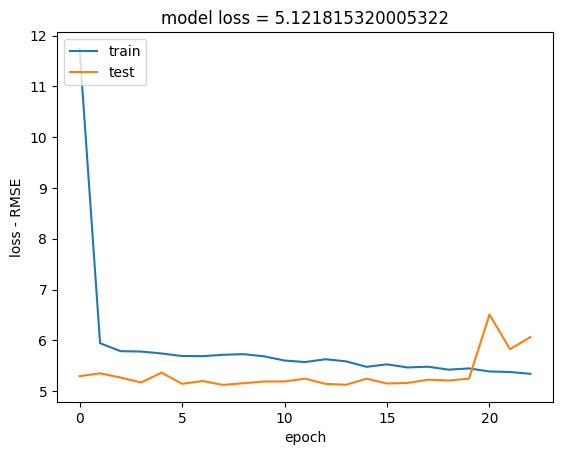


Getestete Architekturen: 50
Best val_loss: 25.003458
Best config: {'time_layers': [128, 64], 'static_layers': [128], 'merge_layers': []} Params: 34177


In [ ]:
# -------------------------------------------------------------
# --- Global reproducibility ---
# -------------------------------------------------------------
BASE_SEED = 228
os.environ["PYTHONHASHSEED"] = str(BASE_SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
random.seed(BASE_SEED)
np.random.seed(BASE_SEED)
tf.random.set_seed(BASE_SEED)

# -------------------------------------------------------------
# --- Fixed hyperparameters ---
# -------------------------------------------------------------
ACTIV       = "relu"
DROPOUT     = 0.15
BATCH_SIZE  = 128
EPOCHS      = 200
PATIENCE    = 15

# -------------------------------------------------------------
# --- Search space (architecture only) ---
# -------------------------------------------------------------
TIME_UNITS    = [32, 64, 128, 256]
TIME_DEPTH    = [1, 2, 3]
STATIC_UNITS  = [32, 64, 128, 256]
STATIC_DEPTH  = [1, 2, 3]
MERGE_UNITS   = [32, 64, 128, 256]
MERGE_DEPTH   = [0, 1, 2]
N_TRIALS = 50

rng = np.random.RandomState(BASE_SEED)

# -------------------------------------------------------------
# --- Helper: sample monotonically decreasing layer structure ---
# -------------------------------------------------------------
def sample_monotone(units_pool, depth):
    """Generates e.g. [256,128,64] or [128,128] — never increasing."""
    layers, prev = [], None
    for _ in range(depth):
        cand = [u for u in units_pool if prev is None or u <= prev]
        u = int(rng.choice(cand))
        layers.append(u)
        prev = u
    return layers

# -------------------------------------------------------------
# --- Sample a random architecture ---
# -------------------------------------------------------------
def sample_architecture(rng):
    t_depth = int(rng.choice(TIME_DEPTH))
    time_layers = sample_monotone(TIME_UNITS, t_depth)

    s_depth = int(rng.choice(STATIC_DEPTH))
    static_layers = sample_monotone(STATIC_UNITS, s_depth)

    m_depth = int(rng.choice(MERGE_DEPTH))
    merge_layers = sample_monotone(MERGE_UNITS, m_depth) if m_depth > 0 else []

    return {
        "time_layers": time_layers,
        "static_layers": static_layers,
        "merge_layers": merge_layers
    }

# -------------------------------------------------------------
# --- Random search ---
# -------------------------------------------------------------
results = []
best = {"val_loss": float("inf"), "cfg": None, "weights": None, "n_params": None}

for trial in range(N_TRIALS):
    cfg = sample_architecture(rng)

    early_stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.8,
        patience=6,
        min_lr=1e-5,
        verbose=0
    )

    callbacks_train = [plot_losses, early_stop, reduce_lr]  # if plot_losses exists

    model = create_supervised(
        input_shape_time=input_shape_time,
        input_shape_static=input_shape_static,
        output_shape=1,
        time_layers=cfg["time_layers"],
        static_layers=cfg["static_layers"],
        merge_layers=cfg["merge_layers"],
        activ=ACTIV,
        dropout=DROPOUT,
        seed=BASE_SEED
    )

    hist = model.fit(
        x=[X_time_train, X_static_train],
        y=y_train,
        validation_data=([X_time_val, X_static_val], y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=False,
        verbose=0,
        callbacks=callbacks_train
    )

    val_loss = float(min(hist.history["val_loss"]))
    n_params = model.count_params()
    results.append((val_loss, n_params, cfg, model.get_weights()))

    if val_loss < best["val_loss"]:
        best.update({
            "val_loss": val_loss,
            "cfg": cfg,
            "weights": model.get_weights(),
            "n_params": n_params
        })

print(f"\nTested architectures: {len(results)}")
print("Best val_loss:", round(best["val_loss"], 6))
print("Best config:", best["cfg"], "Params:", best["n_params"])

# -------------------------------------------------------------
# --- Final evaluation on test set ---
# -------------------------------------------------------------
supervised = create_supervised(
    input_shape_time=input_shape_time,
    input_shape_static=input_shape_static,
    output_shape=1,
    time_layers=best["cfg"]["time_layers"],
    static_layers=best["cfg"]["static_layers"],
    merge_layers=best["cfg"]["merge_layers"],
    activ=ACTIV,
    dropout=DROPOUT,
    seed=BASE_SEED
)
supervised.set_weights(best["weights"])


In [57]:
supervised.summary()

Model: "FF_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_time          │ (None, 10, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_50          │ (None, 30)        │          0 │ input_time[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_305 (Dense)   │ (None, 128)       │      3,968 │ flatten_50[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_static        │ (None, 169)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_306 (Dense)   │ (None, 64)        │      8,256 │ dense_305[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_307 (Dense)   │ (None, 128)       │     21,760 │ input_static[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_50      │ (None, 192)       │          0 │ dense_306[0][0],  │
│ (Concatenate)       │                   │            │ dense_307[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 192)       │          0 │ concatenate_50[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_308 (Dense)   │ (None, 1)         │        193 │ dropout_50[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,177 (133.50 KB)

 Trainable params: 34,177 (133.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Model initialization with input shape and architecture parameters

#### Evaluation of the Model

In [58]:
# --- Compute RMSE between true and predicted values ---
def compute_cost(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_pred - y_true)**2))
    return rmse

In [83]:
def plot_result(y_true, y_pred, band=None):
    """
    Plot actual vs. predicted with y=x and an optional ±band, 
    print MAE/RMSE/R², and return a metrics DataFrame.

    Args:
        y_true, y_pred: array-like of shape (n_samples,)
        band: float or None — half-width (in seconds) around y=x

    Returns:
        pd.DataFrame with columns ["Metric", "Value"]
    """
    # Align arrays and drop NaNs
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true, y_pred = y_true[mask], y_pred[mask]

    # Residuals and metrics
    residuals = y_true - y_pred
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    metrics_df = pd.DataFrame({
        "Metric": ["Mean Absolute Error (MAE) [s]",
                   "Root Mean Square Error (RMSE) [s]",
                   "R² Score"],
        "Value": [round(mae, 2), round(rmse, 2), round(r2, 3)]
    })
    print(metrics_df.to_string(index=False))

    # Scatter: actual vs predicted
    plt.figure(figsize=(9, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, label="Samples")

    xy_min = min(y_true.min(), y_pred.min())
    xy_max = max(y_true.max(), y_pred.max())

    # y = x reference
    plt.plot([xy_min, xy_max], [xy_min, xy_max], 'r--', label="y = x")

    # Optional ±band around y = x
    if band is not None and band > 0:
        xs = np.linspace(xy_min, xy_max, 200)
        plt.plot(xs, xs + band, 'r:', linewidth=1)
        plt.plot(xs, xs - band, 'r:', linewidth=1)
        plt.fill_between(xs, xs - band, xs + band, alpha=0.08)

    plt.xlabel("Actual AROT [s]")
    plt.ylabel("Predicted AROT [s]")
    plt.title("Actual vs Predicted AROT")
    plt.xlim(xy_min, xy_max)
    plt.ylim(xy_min, xy_max)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [86]:
def plot_result_plotly(y_true, y_pred, show_cdf=True):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    residuals = y_true - y_pred
    abs_errors = np.abs(residuals)

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    metrics_df = pd.DataFrame({
        "Metric": [
            "Mean Absolute Error (MAE) [s]",
            "Root Mean Square Error (RMSE) [s]",
            "R² Score"
        ],
        "Value": [round(mae, 2), round(rmse, 2), round(r2, 2)]
    })
    print(metrics_df.to_string(index=False))

    output_dir = 'Plots'
    os.makedirs(output_dir, exist_ok=True)

    comparison_df = pd.DataFrame({
        "Actual ROT": y_true,
        "Residual (signed)": residuals
    })

    # 1) Residual scatter plot
    scatter = go.Scatter(
        x=comparison_df['Actual ROT'],
        y=comparison_df['Residual (signed)'],
        mode='markers',
        marker=dict(size=10, color='blue', line=dict(width=1, color='black'), opacity=0.6),
        name='Residuals'
    )
    zero_line = go.Scatter(
        x=[comparison_df['Actual ROT'].min(), comparison_df['Actual ROT'].max()],
        y=[0, 0],
        mode='lines',
        line=dict(color='red', dash='dash'),
        name='Zero Line'
    )

    fig_scatter = go.Figure(data=[scatter, zero_line])
    fig_scatter.update_layout(
        width=800,
        height=500,
        xaxis=dict(title='Actual AROT [s]', title_font=dict(size=18), tickfont=dict(size=14)),
        yaxis=dict(title='Residuals [s]', title_font=dict(size=18), tickfont=dict(size=14)),
        showlegend=True,
        legend=dict(x=0.01, y=0.99),
        margin=dict(l=40, r=40, t=20, b=40)
    )
    fig_scatter.write_image(os.path.join(output_dir, 'residual_scatter_plot.png'), scale=5)
    fig_scatter.show()

    # 2) Absolute-error CDF (optional)
    if show_cdf:
        sorted_errors = np.sort(abs_errors)
        cumulative_probs = np.linspace(0, 1, len(sorted_errors))

        median_error = np.quantile(abs_errors, 0.5)
        q90_error = np.quantile(abs_errors, 0.9)

        cdf_plot = go.Scatter(
            x=sorted_errors,
            y=cumulative_probs,
            mode='lines',
            line=dict(color='blue', width=2),
            showlegend=False
        )

        median_line = go.Scatter(
            x=[median_error, median_error],
            y=[0, 0.5],
            mode='lines',
            line=dict(color='green', dash='dash', width=2),
            showlegend=False
        )
        q90_line = go.Scatter(
            x=[q90_error, q90_error],
            y=[0, 0.9],
            mode='lines',
            line=dict(color='red', dash='dash', width=2),
            showlegend=False
        )

        median_hline = go.Scatter(
            x=[0, median_error],
            y=[0.5, 0.5],
            mode='lines',
            line=dict(color='green', dash='dot', width=2),
            showlegend=False
        )
        q90_hline = go.Scatter(
            x=[0, q90_error],
            y=[0.9, 0.9],
            mode='lines',
            line=dict(color='red', dash='dot', width=2),
            showlegend=False
        )

        median_text = go.Scatter(
            x=[median_error + 2.2],
            y=[0.2],
            mode='text',
            text=[f'{median_error:.2f}s'],
            textfont=dict(size=17),
            showlegend=False
        )
        median_label = go.Scatter(
            x=[1.8],
            y=[0.53],
            mode='text',
            text=['Median'],
            textfont=dict(size=17),
            showlegend=False
        )
        q90_text = go.Scatter(
            x=[q90_error + 2.2],
            y=[0.2],
            mode='text',
            text=[f'{q90_error:.2f}s'],
            textfont=dict(size=17),
            showlegend=False
        )
        q90_label = go.Scatter(
            x=[4],
            y=[0.93],
            mode='text',
            text=['90th Quantile'],
            textfont=dict(size=17),
            showlegend=False
        )

        layout_cdf = go.Layout(
            xaxis=dict(title='Absolute Error [s]', title_font=dict(size=20), tickfont=dict(size=16), dtick=2, range=[0, sorted_errors.max()]),
            yaxis=dict(title='Cumulative Probability', title_font=dict(size=20), tickfont=dict(size=16)),
            margin=dict(l=10, r=10, t=10, b=10),
            width=1000,
            height=500,
            showlegend=False
        )

        fig_cdf = go.Figure(data=[
            cdf_plot,
            median_line, q90_line,
            median_hline, q90_hline,
            median_text, median_label,
            q90_text, q90_label
        ], layout=layout_cdf)

        fig_cdf.write_image(os.path.join(output_dir, 'absolute_error_cdf.pdf'), scale=5)
        fig_cdf.show()


#### Evaluation of the final trained Model on the Training Data

606/606 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Train RMSE = 5.0
                           Metric  Value
    Mean Absolute Error (MAE) [s]  3.870
Root Mean Square Error (RMSE) [s]  4.960
                         R² Score  0.359


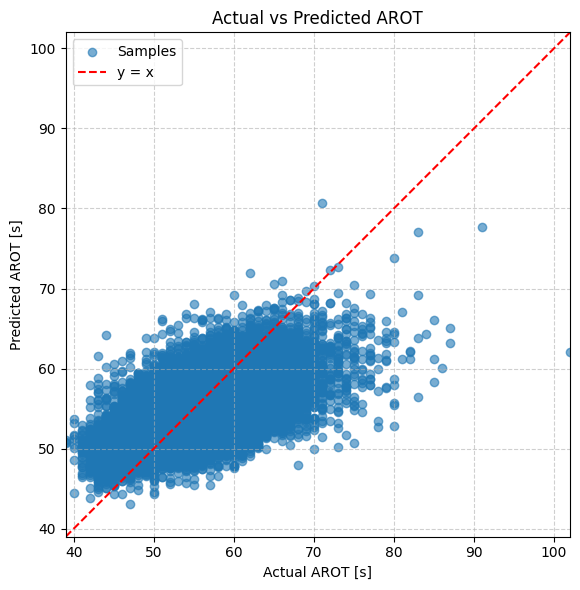

In [84]:
# Predict on training data
y_hat_train = supervised.predict(x=[X_time_train, X_static_train])
y_hat_train = np.ravel(y_hat_train)

# Compute RMSE manually (for older sklearn versions)
rmse_train = np.sqrt(mean_squared_error(y_train, y_hat_train))

# Report Results
print("\nTrain RMSE =", np.round(rmse_train, 1))

# Plot residual analysis
plot_result(y_true=y_train, y_pred=y_hat_train)


#### Evaluation of final Model on the Validation Data

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation RMSE = 5.0
                           Metric  Value
    Mean Absolute Error (MAE) [s]  3.930
Root Mean Square Error (RMSE) [s]  5.000
                         R² Score  0.344


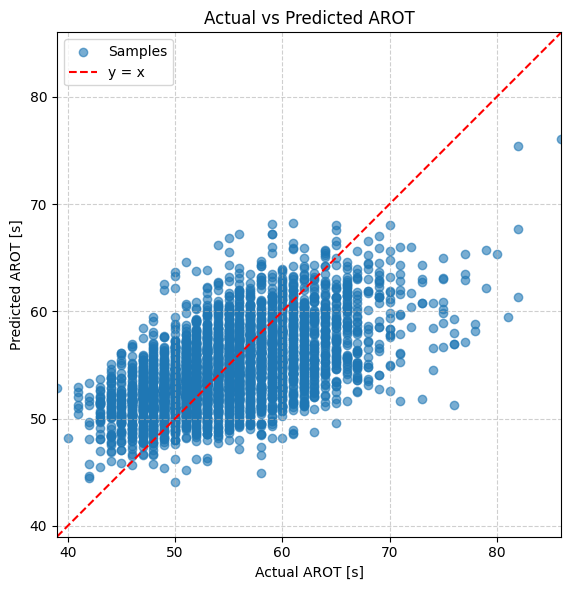

In [85]:
# Model prediction
y_hat_val = supervised.predict(x=[X_time_val, X_static_val])
y_hat_val = np.ravel(y_hat_val)

# Compute RMSE (Root Mean Squared Error)
rmse_val = np.sqrt(mean_squared_error(y_val, y_hat_val))

# Report RMSE
print("Validation RMSE =", round(rmse_val, 2))

# Plot residual analysis (residual = true - predicted)
plot_result(y_true=y_val, y_pred=y_hat_val)


#### Evaluation of final Model on the Test Data

In [88]:
# Model prediction
y_hat_test = supervised.predict(x=[X_time_test,X_static_test])
y_hat_test = np.ravel(y_hat_test)

# Compute RMSE (Root Mean Squared Error)
rmse_test = np.sqrt(mean_squared_error(y_test, y_hat_test))

# Report RMSE
print("Test RMSE =", round(rmse_test, 2))

# Plot residual analysis (residual = true - predicted)
plot_result_plotly(y_true=y_test, y_pred=y_hat_test)

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test RMSE = 5.01
                           Metric  Value
    Mean Absolute Error (MAE) [s]   3.95
Root Mean Square Error (RMSE) [s]   5.01
                         R² Score   0.32


In [89]:
y_true = np.array(y_test).ravel()
y_pred = np.array(y_hat_test).ravel()
residuals = y_true - y_pred
abs_errors = np.abs(residuals)

In [90]:
residuals_pd = pd.DataFrame(residuals, columns=["Residuals"], index=index)


In [91]:
residuals_pd["RET"] = data_rot.loc[residuals_pd.index, "RET"]

In [92]:
residuals_pd["Actual ROT"] = data_rot.loc[residuals_pd.index, "ROT [s]"]

In [93]:
residuals_pd["Predicted ROT"] = y_pred

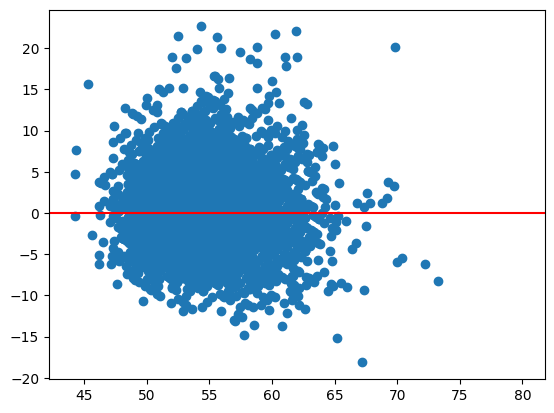

In [94]:
plt.scatter(residuals_pd['Predicted ROT'], residuals_pd['Residuals'])
plt.axline((44,0), (80,0), color="red")

#### Permutation Feature Importance for Static and Time-Dependent Inputs

In [ ]:
# --- Ensure reproducibility across NumPy, random, and TensorFlow ---
def set_global_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    try:
        tf.random.set_seed(seed)
    except ImportError:
        pass

set_global_seed(42)

# --- Group static features by semantic prefixes ---
def define_feature_groups(feature_names):
    prefixes = {
        "Aircraft Type": "A/C Type_",
        "ICAO Code": "ICAO Code_",
        "Day of Week": "Day of week ",
        "Month": "Month ",
        "Predicted RET Probabilities": "prob_",
    }
    groups = {
        key: [i for i, name in enumerate(feature_names) if name.startswith(prefix)]
        for key, prefix in prefixes.items()
    }
    # Assign remaining features to individual groups
    for i, name in enumerate(feature_names):
        if not any(i in idxs for idxs in groups.values()):
            groups[name] = [i]
    return groups

# --- Grouped permutation importance for static features ---
def permutation_importance_grouped(model, X_time, X_static, y, groups, n_repeats=30):
    if isinstance(X_static, pd.DataFrame):
        X_static = X_static.astype(np.float32).values
    elif isinstance(X_static, np.ndarray) and X_static.dtype != np.float32:
        X_static = X_static.astype(np.float32)

    base_pred = model.predict([X_time, X_static], verbose=0).flatten()
    base_rmse = np.sqrt(mean_squared_error(y, base_pred))
    results = {}

    for name, idxs in groups.items():
        diffs = []
        for _ in range(n_repeats):
            perm = np.random.permutation(X_static.shape[0])
            X_static_perm = X_static.copy()
            X_static_perm[:, idxs] = X_static[perm][:, idxs]
            pred = model.predict([X_time, X_static_perm], verbose=0).flatten()
            rmse_perm = np.sqrt(mean_squared_error(y, pred))
            diffs.append(rmse_perm - base_rmse)
        results[name] = {
            'mean': np.mean(diffs),
            'std': np.std(diffs)
        }
    return results

# --- Permutation importance for time-series features ---
def permutation_importance_time(model, X_time, X_static, y, time_features, n_repeats=30):
    base_rmse = np.sqrt(mean_squared_error(y, model.predict([X_time, X_static], verbose=0).flatten()))
    results = {}
    for i, name in enumerate(time_features):
        diffs = []
        for _ in range(n_repeats):
            perm = np.random.permutation(len(X_time))
            X_time_perm = X_time.copy()
            X_time_perm[:, :, i] = X_time[perm, :, i]
            pred = model.predict([X_time_perm, X_static], verbose=0).flatten()
            diffs.append(np.sqrt(mean_squared_error(y, pred)) - base_rmse)
        results[name] = {'mean': np.mean(diffs), 'std': np.std(diffs)}
    return results

# --- Apply human-readable feature name mapping ---
def apply_name_mapping(importance_dict, name_map):
    return {name_map.get(k, k): v for k, v in importance_dict.items()}

# --- Plot permutation feature importance using Plotly ---
def plot_feature_importance(importance, cat_map, out_path=None):
    categories = {
        'Aircraft-Specific Features': 'steelblue',
        'Airport-Specific Features': 'teal',
        'Sequential Features': 'purple',
        'Temporal Features': 'green',
        'Trajectory Features': 'orange',
        'Weather Features': 'red',
    }

    df = pd.DataFrame([
        {'Feature': k, 'Mean': v['mean'], 'Std': v['std']}
        for k, v in importance.items()
    ])
    df = df.sort_values(by='Mean', ascending=False)

    colors = [categories.get(cat_map.get(f, ''), 'gray') for f in df['Feature']]

    fig = go.Figure(go.Bar(
        x=df['Mean'], y=df['Feature'], orientation='h',
        error_x=dict(type='data', array=df['Std']),
        marker=dict(color=colors), name=''
    ))

    for cat, color in categories.items():
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=color),
            showlegend=True, name=cat
        ))

    fig.for_each_trace(lambda t: t.update(showlegend=False) if t.name == '' else None)

    fig.update_layout(
        xaxis=dict(title='Increase in RMSE [s]', title_font=dict(size=30), tickfont=dict(size=24)),
        yaxis=dict(title='Feature', title_font=dict(size=30), tickfont=dict(size=24), autorange='reversed'),
        margin=dict(l=150, r=50, t=50, b=50),
        showlegend=True,
        legend=dict(font=dict(size=24), x=1, y=0, xanchor="right", yanchor="bottom"),
        height=800 + len(df) * 20,
        width=1800,
        template='plotly_white'
    )

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.write_image(out_path, scale=5)
    fig.show()

# --- Mapping from raw feature names to formatted display names (for plots or tables) ---
formatted_names_mapping = {
    'MALW kg': 'MALW [kg]',
    'ICAO Code': 'Airline',
    'A/C Type': 'Aircraft Type',
    'Number of Engines': 'Number of Engines',
    'Propulsion Type': 'Propulsion Type',
    'groundspeed': 'Groundspeed [kt]',
    'groundspeed at prediction': 'Groundspeed [kt]',
    'distance': 'Distance to TH [NM]',
    'geoaltitude': 'Geoaltitude [ft]',
    'vertical_rate': "Vertical Rate [ft/min]",
    'Hour sin': 'Hour sin',
    'Hour cos': 'Hour cos',
    'Day of week sin': 'Day of week sin',
    'Day of week cos': 'Day of week cos',
    'Temperature °C': 'Temperature [°C]',
    'temp_2m': 'Temperature [°C]',
    'Headwind kt': 'Headwind [kt]',
    "new_headwind_kt": "Headwind [kt]",
    'Crosswind kt': 'Crosswind [kt]',
    'new_crosswind_kt': 'Crosswind [kt]',
    'Visibility Category': 'Visibility Category',
    'Precipitation mm': 'Precipitation [mm]',
    'precip_10min': 'Precipitation [mm]',
    'pressure_qnh': 'Pressure [hPa]',
    'Arrival Traffic Intensity with go-arounds': 'Arrival Traffic Intensity',
    'Time from Previous Landing s': 'Time from Previous Landing [s]',
    'Average ROT Previous Flight same A/C Type Total [s]': 'Average AROT same A/C Type [s]',
    'Number of Successive Traffic': 'Number of Successive Aircraft',
    'Successive Traffic Distance': 'Distance to Successive Aircraft [NM]',
    'Successive Traffic Groundspeed': 'Successive Aircraft Groundspeed [kt]',
    'prob_H1': 'Predicted Probability H1',
    'prob_H2': 'Predicted Probability H2',
    'prob_H3': 'Predicted Probability H3',
    'Successive Traffic Geoaltitude': 'Successive Aircraft Geoaltitude [ft]',
    'Number of preceding Traffic': 'Number of Preceding Aircraft',
    'Distance to Preceding Aircraft': 'Distance to Preceding Aircraft [NM]',
}

# --- Feature category mapping for grouping and visualization ---
feature_category_mapping = {
    'MALW [kg]': 'Aircraft-Specific Features',
    'Airline': 'Aircraft-Specific Features',
    'Aircraft Type': 'Aircraft-Specific Features',
    'Number of Engines': 'Aircraft-Specific Features',
    'Propulsion Type': 'Aircraft-Specific Features',
    'Gate Region': 'Airport-Specific Features',
    'Groundspeed [kt]': 'Trajectory Features',
    'Geoaltitude [ft]': 'Trajectory Features',
    'Vertical Rate [ft/min]': 'Trajectory Features',
    'Distance to TH [NM]': 'Trajectory Features',
    'Hour': 'Temporal Features',
    'Day of Week': 'Temporal Features',
    'Month': 'Temporal Features',
    'Temperature [°C]': 'Weather Features',
    'Headwind [kt]': 'Weather Features',
    'Crosswind [kt]': 'Weather Features',
    'Visibility Category': 'Weather Features',
    'Precipitation [mm]': 'Weather Features',
    'Pressure [hPa]': 'Weather Features',
    'Arrival Traffic Intensity': 'Traffic Intensity',
    'Time from Previous Landing [s]': 'Sequential Features',
    'Average AROT same A/C Type [s]': 'Aircraft-Specific Features',
    'Number of Successive Aircraft': 'Sequential Features',
    'Distance to Successive Aircraft [NM]': 'Sequential Features',
    'Successive Aircraft Groundspeed [kt]': 'Sequential Features',
    'Successive Aircraft Geoaltitude [ft]': 'Sequential Features',
    'Successor Aligned': 'Sequential Features',
    'Predicted Probability H1': 'Airport-Specific Features',
    'Predicted Probability H2': 'Airport-Specific Features',
    'Predicted Probability H3': 'Airport-Specific Features',
    'Predicted RET Probabilities': 'Airport-Specific Features',
    'Number of Preceding Aircraft': 'Sequential Features',
    'Distance to Preceding Aircraft [NM]': 'Sequential Features',
}




# --- Execute importance analysis and plot results ---
feature_names_static = X_static.columns.tolist()
groupings = define_feature_groups(feature_names_static)

static_importance = permutation_importance_grouped(
    model=supervised,
    X_time=X_time_test,
    X_static=X_static_test,
    y=y_test,
    groups=groupings,
    n_repeats=100
)

time_importance = permutation_importance_time(
    model=supervised,
    X_time=X_time_test,
    X_static=X_static_test,
    y=y_test,
    time_features=['groundspeed', 'geoaltitude', 'vertical_rate'],
    n_repeats=100
)

combined_importance_raw = {**static_importance, **time_importance}
combined_importance = apply_name_mapping(combined_importance_raw, formatted_names_mapping)

# --- Save raw and named importance results as JSON before plotting ---
os.makedirs("Plots", exist_ok=True)

with open("Plots/Feature_importance_combined_raw.json", "w") as f:
    json.dump(combined_importance_raw, f, indent=4)

with open("Plots/Feature_importance_combined_named.json", "w") as f:
    json.dump(combined_importance, f, indent=4)



plot_feature_importance(
    importance=combined_importance,
    cat_map=feature_category_mapping,
    out_path="Plots/Feature_importance_plot.pdf"
)


In [95]:
def plot_feature_importance_collapsed(
    importance: dict,
    cat_map: dict,
    collapse_categories=("Temporal Features", "Trajectory Features"),
    out_path=None
):
    """
    Collapse selected categories into single bars and show all other features individually.
    importance: {feature: {'mean': float, 'std': float}}
    cat_map:    {feature_name: category_name} (may be incomplete)
    """

    # Helper: robustly infer a category for a feature
    def _infer_category(feat: str) -> str:
        # 1) direct mapping
        if feat in cat_map:
            return cat_map[feat]

        # 2) temporal feature heuristics (sin/cos encodings, etc.)
        low = feat.lower()
        if low.startswith("hour") or low.startswith("day of week") or low.startswith("month"):
            return "Temporal Features"

        # 3) trajectory feature heuristics
        traj_keys = [
            "groundspeed", "geoa", "vertical rate", "distance to th",
            "groundspeed [kt]", "geoaltitude [ft]", "vertical rate [ft/min]"
        ]
        if any(k in low for k in traj_keys):
            return "Trajectory Features"

        return "Other"

    # Colors per category (with fallback)
    category_colors = {
        'Aircraft-Specific Features': 'steelblue',
        'Airport-Specific Features': 'teal',
        'Sequential Features': 'purple',
        'Temporal Features': 'green',
        'Trajectory Features': 'orange',
        'Weather Features': 'red',
        'Traffic intensity': 'purple',
        'Other': 'gray'
    }

    # Build DataFrame from importance dict
    rows = []
    for feat, stats in importance.items():
        rows.append({
            "Feature": feat,
            "Category": _infer_category(feat),
            "Mean": float(stats["mean"]),
            "Std": float(stats["std"])
        })
    df = pd.DataFrame(rows)

    # Collapse selected categories (sum of means; std via root-sum-of-squares)
    collapsed_rows = []
    for cat in collapse_categories:
        sub = df[df["Category"] == cat]
        if len(sub) == 0:
            continue
        collapsed_rows.append({
            "Feature": cat,
            "Category": cat,
            "Mean": sub["Mean"].sum(),
            "Std": np.sqrt((sub["Std"]**2).sum())
        })

    # Keep features not in the collapsed categories
    keep = df[~df["Category"].isin(collapse_categories)].copy()

    # Final frame: collapsed categories + individual features
    final_df = pd.concat([pd.DataFrame(collapsed_rows), keep], ignore_index=True)
    final_df = final_df.sort_values("Mean", ascending=False)
    final_df["Color"] = final_df["Category"].map(category_colors).fillna("gray")

    # Plotly bar chart
    fig = go.Figure(
        go.Bar(
            x=final_df["Mean"],
            y=final_df["Feature"],
            orientation='h',
            error_x=dict(type='data', array=final_df["Std"]),
            marker=dict(color=final_df["Color"]),
            name=''
        )
    )

    # Legend entries (dummy traces per category)
    for cat, color in category_colors.items():
        if (final_df["Category"] == cat).any():
            fig.add_trace(go.Scatter(
                x=[None], y=[None], mode='markers',
                marker=dict(size=10, color=color),
                showlegend=True, name=cat
            ))

    # Hide the real bar trace in legend
    fig.for_each_trace(lambda t: t.update(showlegend=False) if t.name == '' else None)

    fig.update_layout(
        xaxis=dict(title='Increase in RMSE [s]', title_font=dict(size=34), tickfont=dict(size=28)),
        yaxis=dict(title='', tickfont=dict(size=28), autorange='reversed'),
        margin=dict(l=250, r=60, t=40, b=60),
        showlegend=True,
        legend=dict(font=dict(size=26), x=1, y=0, xanchor="right", yanchor="bottom"),
        height=700 + len(final_df) * 18,
        width=1800,
        template='plotly_white'
    )

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.write_image(out_path, scale=5)

    fig.show()


# Plot
plot_feature_importance_collapsed(
    importance=combined_importance,
    cat_map=feature_category_mapping,
    collapse_categories=("Temporal Features", "Trajectory Features"),
    out_path="Plots/Feature_importance_plot_collapsed.pdf"
)


#### Plot Histogram of Time Buffers Between Successive Landings


In [ ]:
# --- Filter for time differences less than 120 seconds ---
filtered_diff = data_buffer_plot['Time Difference (s)'][data_buffer_plot['Time Difference (s)'] < 120].dropna()

# --- Create histogram using Plotly ---
histogram = go.Figure()
histogram.add_trace(
    go.Histogram(
        x=filtered_diff,
        xbins=dict(start=0, end=120, size=1),
        marker=dict(color='blue', line=dict(width=1, color='black')),
        opacity=0.7
    )
)

# --- Customize layout (static styling, no interactivity) ---
histogram.update_layout(
    xaxis=dict(
        title='Time Difference [s]',
        title_font=dict(size=20),
        tickfont=dict(size=16)
    ),
    yaxis=dict(
        title='Count',
        title_font=dict(size=20),
        tickfont=dict(size=16)
    ),
    margin=dict(l=40, r=40, t=20, b=40),
    showlegend=False
)

# --- Ensure output folder exists ---
output_dir = 'Plots'
os.makedirs(output_dir, exist_ok=True)

# --- Export histogram to PDF using Kaleido ---
histogram.write_image(os.path.join(output_dir, 'Time_buffer_hist_v1.pdf'), scale=5)

# --- Display plot ---
histogram.show()


#### Histogram of Observed AROT Distribution


In [96]:
# Histogram of ROT [s]
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=data['ROT [s]'],
    xbins=dict(size=1),
    marker=dict(line=dict(width=1, color='black'))
))

# Layout
fig.update_layout(
    xaxis=dict(title="Observed AROT [s]", title_font=dict(size=22), tickfont=dict(size=18), range=[0, 121]),
    yaxis=dict(title="Count", title_font=dict(size=22), tickfont=dict(size=18)),
    showlegend=False,
    margin=dict(l=40, r=40, t=20, b=40)
)

# Save and show
output_dir = 'Plots'
os.makedirs(output_dir, exist_ok=True)
fig.write_image(os.path.join(output_dir, 'ROT_distribution_hist_v2.pdf'), scale=5)
fig.show()


#### Mean AROT in complete dataset

In [99]:
data['ROT [s]'].mean()

np.float64(54.7110428124663)

#### Standard Deviation of AROT in complete dataset

In [100]:
data['ROT [s]'].std()

np.float64(6.201259702159901)

#### Median of AROT in complete dataset

In [76]:
data['ROT [s]'].median()

np.float64(54.0)

In [101]:
data['ROT [s]'].max()

np.float64(110.0)

#### Bar Chart of RET Class Distribution


In [78]:
# --- Count absolute and relative frequencies --- 
ret_counts_abs = data['RET'].value_counts().sort_values(ascending=True)
ret_counts_rel = data['RET'].value_counts(normalize=True).sort_values(ascending=True) * 100

# --- Combine absolute and relative values as text labels ---
text_labels = [
    f"{abs_val:,} ({rel_val:.1f}%)"
    for abs_val, rel_val in zip(ret_counts_abs.values, ret_counts_rel.values)
]

# --- Create bar plot with consistent external labeling ---
fig_ret = go.Figure(go.Bar(
    x=ret_counts_abs.values,
    y=ret_counts_abs.index.tolist(),
    orientation='h',
    marker=dict(
        color='steelblue',
        line=dict(color='black', width=1)
    ),
    text=text_labels,
    textposition='outside',
    textfont=dict(size=14, color='black')  # All text placed outside in black
))

# --- Extend x-axis range by 25% for label spacing ---
max_val = ret_counts_abs.max()
x_range_max = max_val * 1.25

# --- Adjust layout ---
fig_ret.update_layout(
    width=800,
    height=400,
    xaxis=dict(
        title='Count',
        title_font=dict(size=18),
        tickfont=dict(size=14),
        range=[0, x_range_max]
    ),
    yaxis=dict(
        title='RET',
        title_font=dict(size=18),
        tickfont=dict(size=14)
    ),
    showlegend=False,
    margin=dict(l=80, r=40, t=20, b=40)
)

# --- Export plot as PDF ---
output_dir = 'Plots'
os.makedirs(output_dir, exist_ok=True)
fig_ret.write_image(os.path.join(output_dir, 'RET_distrubution_V2.png'), scale=5)

# --- Show interactive plot ---
fig_ret.show()
